<a href="https://colab.research.google.com/github/sravanisasu/Aganitha/blob/master/Binary_Classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Morlet Function**

In [207]:
# Morlet Function
def w_func(t):
  return torch.cos(1.75*t)* torch.exp(-(t**2))

**Required imports**

In [208]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os as os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import minmax_scale  
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

**Pre-process the data**

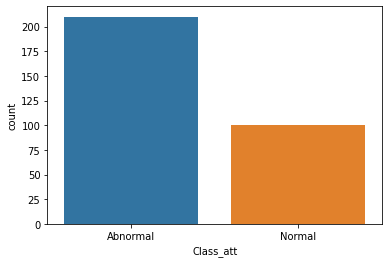

In [209]:
df = pd.read_csv("/content/Dataset_spine.csv")

# applying encoding for the output 0-normal and 1-abnormal
sns.countplot(x = 'Class_att', data=df)
df['Class_att'] = df['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}
df['Class_att'].replace(encode_map, inplace=True)

X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

# apply minmax scalar
X_train = minmax_scale(X_train)
X_test = minmax_scale(X_test)

**Initalise Hyper parameters**

In [210]:
nin = len(X.columns)
nhn = 10
non = 1

EPOCHS = 500
BATCH_SIZE = 16
lr = 0.001
mom = 0.999

**Function for train dataset**

In [211]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

**Function for test dataset**

In [212]:
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

**Load Dataset**

In [213]:
#train
train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

#test
test_data = testData(torch.FloatTensor(X_test))
test_loader = DataLoader(dataset=test_data, batch_size=1)

**Define Model**

In [214]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        self.fc1 = weight_norm(nn.Linear(nin, nhn, bias=False))
        self.fc2 = nn.Linear(nhn, non)
        self.a = nn.Parameter(torch.rand(nhn), requires_grad=True)
        self.b = nn.Parameter(torch.rand(nhn), requires_grad=True)
    def forward(self, x):
        t = (self.fc1(x)-self.b)/self.a
        vk = self.fc2(w_func(t))
        return vk

**Define accuracy function**

In [215]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

**Train the model**

In [216]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#define model
model = binaryClassification()
model.to(device)

#define loss function
criterion = nn.MSELoss()

#define optimiser
optimizer = optim.SGD(model.parameters(),  lr = lr, momentum=mom)

#train model
for e in range(1, EPOCHS+1):

  #check for checkpoint
  if os.path.exists("best.pt"):
      checkpoint = torch.load("best.pt")
      best_loss = checkpoint['loss']
  else:
      best_loss = 999999
  epoch_loss = 0
  epoch_acc = 0
  for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      optimizer.zero_grad()
      
      y_pred = model(X_batch)
      
      loss = criterion(y_pred, y_batch.unsqueeze(1))
      acc = binary_acc(y_pred, y_batch.unsqueeze(1))
      
      loss.backward()
      optimizer.step()
      
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  # update checkpoint with the best model
  if epoch_loss/len(train_loader) < best_loss:
      torch.save({
        'epoch': e,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss/len(train_loader),
        'acc' : epoch_acc/len(train_loader),
      }, "best.pt")      

  print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.66195 | Acc: 34.385
Epoch 002: | Loss: 0.26862 | Acc: 67.692
Epoch 003: | Loss: 0.33750 | Acc: 66.538
Epoch 004: | Loss: 0.28700 | Acc: 66.538
Epoch 005: | Loss: 0.25507 | Acc: 57.077
Epoch 006: | Loss: 0.28880 | Acc: 37.231
Epoch 007: | Loss: 0.26220 | Acc: 43.692
Epoch 008: | Loss: 0.22328 | Acc: 66.385
Epoch 009: | Loss: 0.22884 | Acc: 66.846
Epoch 010: | Loss: 0.22351 | Acc: 66.692
Epoch 011: | Loss: 0.20720 | Acc: 66.077
Epoch 012: | Loss: 0.21640 | Acc: 62.692
Epoch 013: | Loss: 0.21248 | Acc: 65.154
Epoch 014: | Loss: 0.19976 | Acc: 69.077
Epoch 015: | Loss: 0.20463 | Acc: 66.538
Epoch 016: | Loss: 0.20517 | Acc: 67.077
Epoch 017: | Loss: 0.19006 | Acc: 67.154
Epoch 018: | Loss: 0.20417 | Acc: 70.077
Epoch 019: | Loss: 0.18828 | Acc: 70.923
Epoch 020: | Loss: 0.19858 | Acc: 67.923
Epoch 021: | Loss: 0.18543 | Acc: 70.000
Epoch 022: | Loss: 0.18403 | Acc: 73.308
Epoch 023: | Loss: 0.18357 | Acc: 74.769
Epoch 024: | Loss: 0.17425 | Acc: 70.846
Epoch 025: | Los

**Evaluate the model and predict results**

In [218]:
y_pred_list = []

#load the best model from the saved checkpoint
if os.path.exists("best.pt"):
  checkpoint = torch.load("best.pt")
  model.load_state_dict(checkpoint['model_state_dict'])
  print('best epoch :',checkpoint["epoch"],'with loss :', checkpoint["loss"],'with accuracy :', checkpoint["acc"])

#evaluate the model and predict test output
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

#print the roc_auc_score
print(roc_auc_score(y_test, y_pred_list))

best epoch : 498 with loss : 0.07580814725504471 with accuracy : 89.6923076923077
0.7271505376344085
